**Data Source:** Pleschberger, Martin, Zernig, Anja, & Kaestner, Andre. (2020). Equipment Sensor Data from Semiconductor Frontend Production (Version 1) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4282611

In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 100
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sensors_1_to_24 = pd.read_csv('equipment1.csv', sep=';')
sensors_25_to_56 = pd.read_csv('equipment2.csv', sep=';')
response = pd.read_csv('response.csv', sep=';')

In [3]:
sensors_1_to_24.lot = sensors_1_to_24.lot.str.replace('lot', '').astype('int64')
sensors_1_to_24.timestamp = sensors_1_to_24.timestamp.str.replace('timestamp_', '').astype('int64')

sensors_25_to_56.lot = sensors_25_to_56.lot.str.replace('lot', '').astype('int64')
sensors_25_to_56.timestamp = sensors_25_to_56.timestamp.str.replace('timestamp_', '').astype('int64')

In [4]:
grouped_data_1_to_24 = sensors_1_to_24.groupby(['lot', 'wafer']).mean().sort_values('lot')
grouped_data_25_to_56 = sensors_25_to_56.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [5]:
response['lot'] = response['lot'].str.replace('lot', '').astype('int64')
response['class'] = response['class'].replace(['good', 'bad'], [1, 0]).astype('int64')
grouped_response = response.groupby(['lot', 'wafer']).mean().sort_values('lot')

In [6]:
print(len(grouped_response.index) - len(grouped_data_25_to_56.index))
print(len(grouped_response.index) - len(grouped_data_1_to_24.index))

0
348


In [7]:
sensor_data = grouped_data_1_to_24.join(grouped_data_25_to_56, how='outer', lsuffix='_1_to_24', rsuffix='_25_to_56')
data = sensor_data.join(grouped_response, how='outer')

In [8]:
data = data.fillna(0)

In [9]:
data.sample(3)

,,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
lot,wafer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,21,87.5,2.896888,2.897727,66.054947,19.800835,19.801136,0.0,12.434539,0.590021,7.181818,11.544375,12.795455,0.0,0.260739,0.260739,0.259886,0.259830,6.085227,387.952727,102.681773,17.744318,0.452273,211.468716,478.556818,0.864148,87.5,0.001408,218.170221,60.187500,6.869318,0.001932,20.446364,10.343571,75.169698,0.0,0.001857,37.710372,0.0,26.393308,40.794436,39.356395,193.646446,2.456046,121.021149,122.670885,1.017045,521.051853,30.571932,521.079060,16.038239,182.403409,29.598864,179.521591,121.631348,383.376896,0.000007,0.502077,0.607784,0.4950,1
24,17,87.5,2.812555,2.812500,65.198457,19.855889,19.857955,0.0,12.789201,0.587568,7.136364,11.524830,12.806818,0.0,0.266420,0.266420,0.265568,0.265511,6.085227,387.967960,102.071827,17.630682,0.465341,214.881125,455.761364,0.863295,87.5,0.001418,219.008578,61.931818,7.431818,0.001761,21.298295,10.684505,76.601717,0.0,0.001907,38.417570,0.0,26.048415,43.812442,40.924281,200.109082,3.185716,122.510833,124.211022,1.034091,655.760227,31.783636,1322.924534,16.185966,177.477273,31.625000,177.356818,123.888849,404.652320,0.000007,0.492596,0.619489,0.3816,1
49,3,87.5,5.141457,5.236364,13.921448,43.261026,43.061080,0.0,9.833826,1.886077,7.744318,12.221989,13.812500,0.0,0.267435,0.267435,0.267435,0.267435,6.482955,408.219278,99.607921,10.215909,89.489205,215.722886,487.653409,1.033977,87.5,0.001386,123.990194,57.937500,6.437500,0.000000,21.256989,10.380920,75.273970,0.0,0.001860,36.310605,0.0,21.219381,40.622980,39.336838,170.653525,2.616823,114.756358,117.291655,0.982955,397.033653,30.361364,632.147852,15.469830,172.034091,30.915909,172.853977,116.866814,0.000009,419.444501,0.767736,0.586250,0.3960,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1319 entries, (2, 1) to (103, 25)
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_1_to_24   1319 non-null   float64
 1   sensor_1            1319 non-null   float64
 2   sensor_2            1319 non-null   float64
 3   sensor_3            1319 non-null   float64
 4   sensor_4            1319 non-null   float64
 5   sensor_5            1319 non-null   float64
 6   sensor_6            1319 non-null   float64
 7   sensor_7            1319 non-null   float64
 8   sensor_8            1319 non-null   float64
 9   sensor_9            1319 non-null   float64
 10  sensor_10           1319 non-null   float64
 11  sensor_11           1319 non-null   float64
 12  sensor_12           1319 non-null   float64
 13  sensor_13           1319 non-null   float64
 14  sensor_14           1319 non-null   float64
 15  sensor_15           1319 non-null   float64
 

In [11]:
data.describe()

,timestamp_1_to_24,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,timestamp_25_to_56,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56,response,class
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.0,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1.319000e+03,1319.000000,1319.000000,1319.000000
mean,64.414329,2.994615,3.033734,27.737953,23.849106,23.813934,0.101126,7.849907,0.708233,5.411047,8.633491,9.515757,0.218351,0.194300,0.194300,0.194019,0.194008,4.573851,290.510271,78.360541,9.840982,231.050492,155.186543,345.345622,0.700146,87.5,0.001403,154.539367,61.388629,7.010709,0.001700,20.873311,10.445576,75.038648,0.000202,0.001861,38.326207,0.000207,23.872753,41.882245,39.580997,189.514677,2.650611,122.333376,124.302022,1.040673,453.448962,30.591545,783.977135,15.756765,176.676296,30.255056,175.282816,123.584465,198.086621,195.264637,5.419853e-01,0.617882,0.610433,0.799848
std,38.576888,2.067209,2.081444,27.952776,17.395009,17.355720,0.483888,4.857079,0.728064,3.246610,5.178566,5.712414,0.951764,0.116435,0.116435,0.116277,0.116271,2.742306,174.196679,51.773140,6.711553,413.825437,92.994311,207.101672,0.425157,0.0,0.000049,79.418785,4.539808,0.561165,0.001149,0.716157,0.336480,2.559284,0.007353,0.000053,2.818333,0.007509,1.999914,1.827950,1.694330,10.079443,0.658755,9.044779,9.225132,0.090416,226.612973,1.590658,407.874725,0.600415,4.661447,1.611555,4.716476,9.136877,197.519613,196.568782,1.158684e-01,0.045494,0.442395,0.400265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.5,0.001222,4.216210,50.625000,5.585227,0.000000,18.742386,9.322899,64.197888,0.000000,0.001696,31.725676,0.000000,19.200304,36.798038,35.246175,161.202755,0.962720,101.008813,102.426010,0.892045,14.255641,26.636136,72.361073,13.941364,158.500000,25.422727,153.122727,102.367403,0.000003,0.000002,2.907170e-07,0.511534,0.360000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.5,0.001373,103.390709,60.187500,6.778409,0.000000,20.446023,10.218000,73.090327,0.000000,0.001817,37.687526,0.000000,22.598349,40.602276,38.329930,182.127009,2.208014,119.956132,121.636887,1.011364,295.523954,29.430682,452.774723,15.326705,173.210227,29.096591,172.103693,121.243535,0.000007,0.000007,4.892623e-01,0.607131,0.396000,1.000000
50%,87.500000,2.812623,2.812500,13.669946,19.861540,19.857955,0.000000,9.508514,0.585703,7.170455,11.517330,12.755682,0.000000,0.260739,0.260739,0.259886,0.259830,6.085227,387.806114,98.212212,10.028409,80.308523,208.935131,456.392045,0.864318,87.5,0.001403,147.633078,61.312500,6.937500,0.002045,21.013977,10.463086,75.162172,0.000000,0.001860,38.053884,0.000000,24.341112,41.

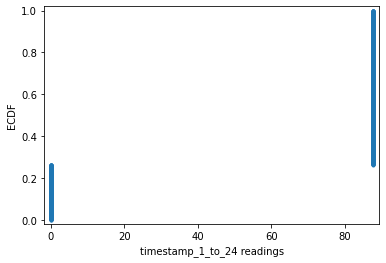

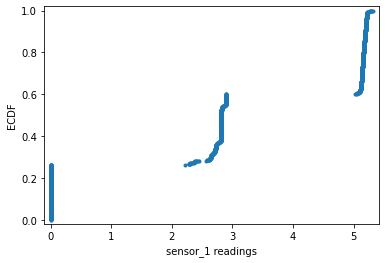

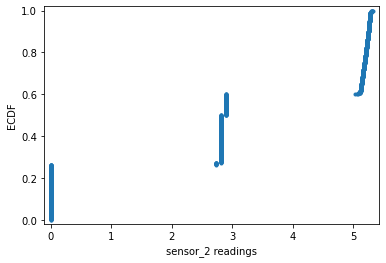

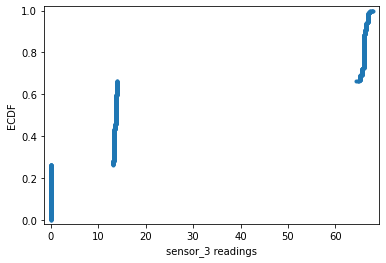

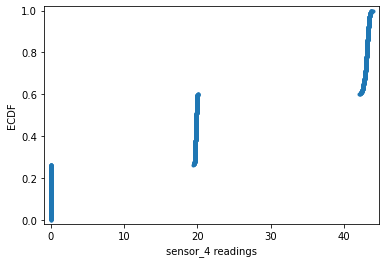

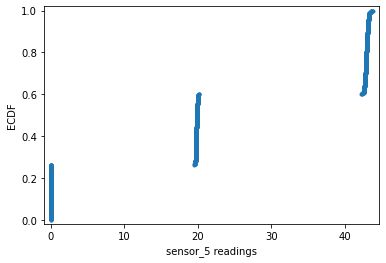

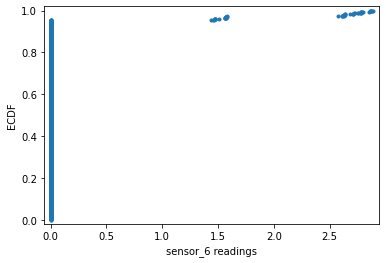

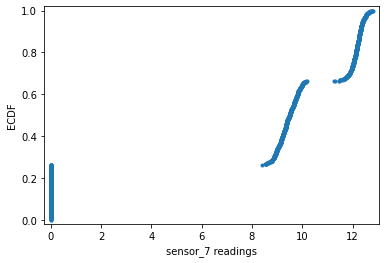

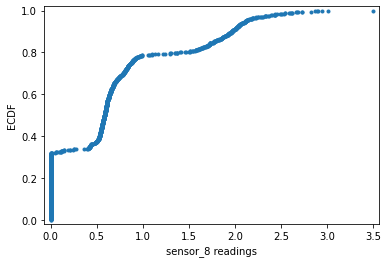

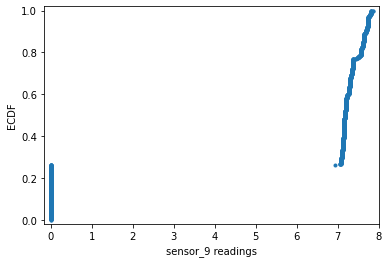

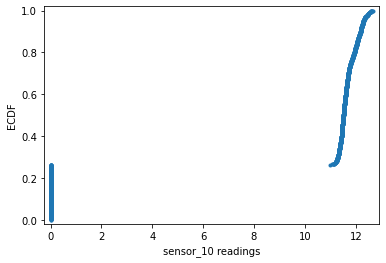

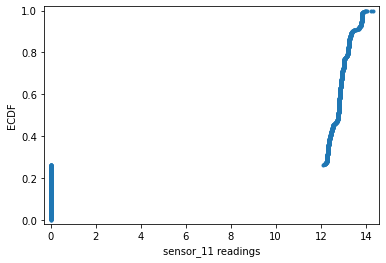

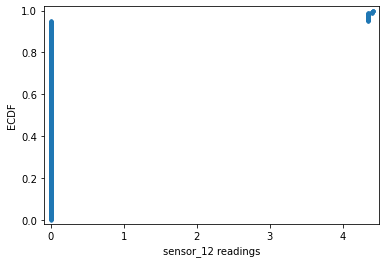

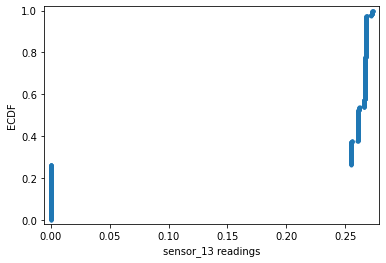

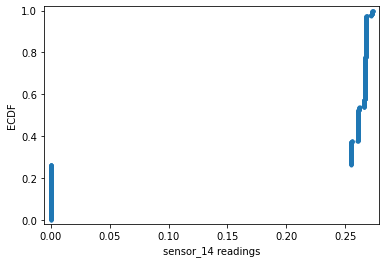

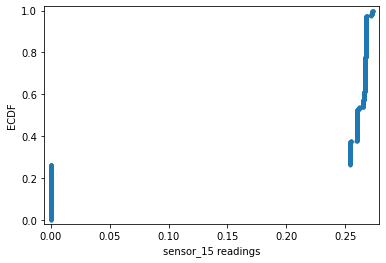

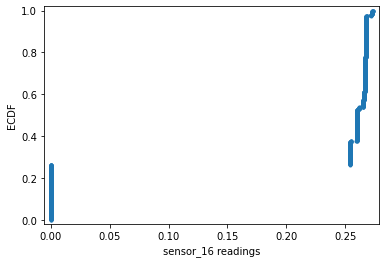

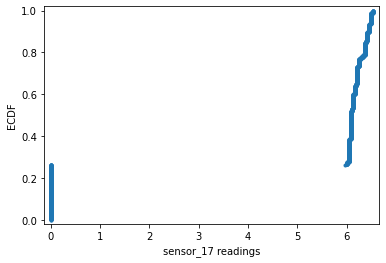

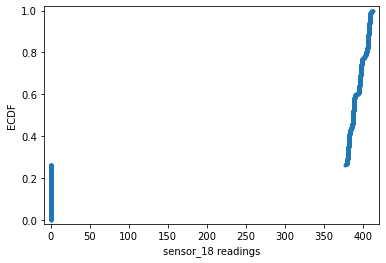

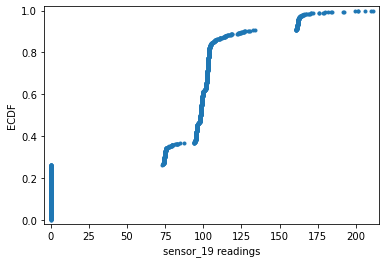

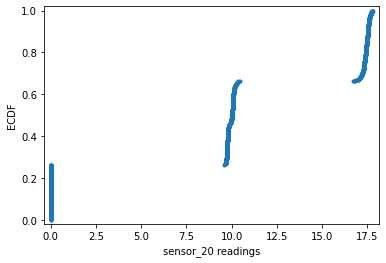

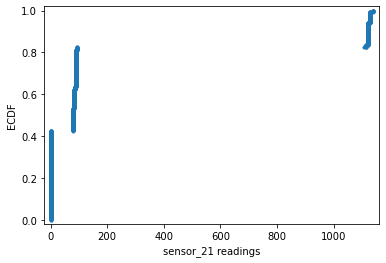

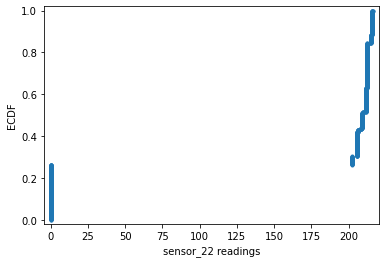

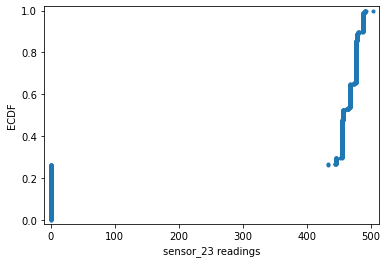

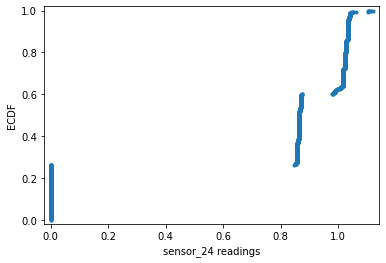

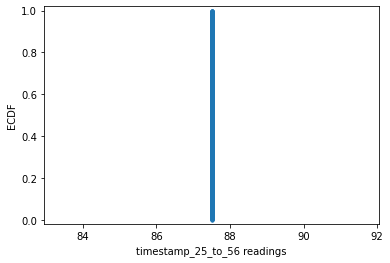

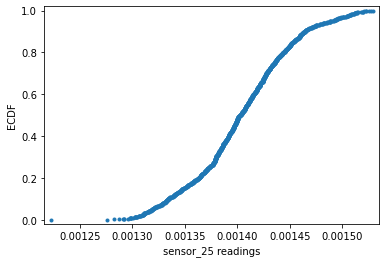

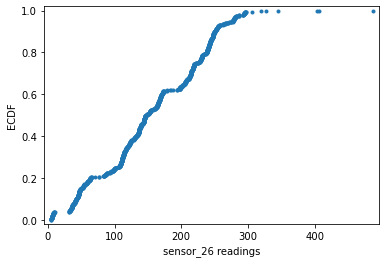

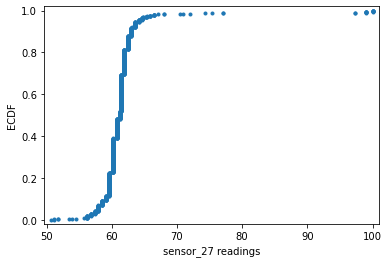

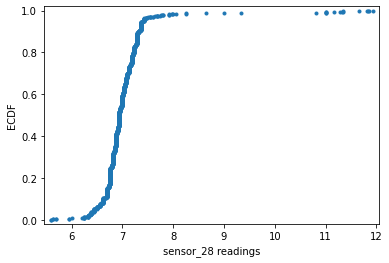

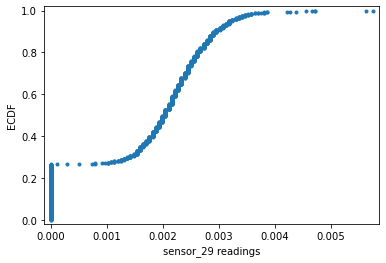

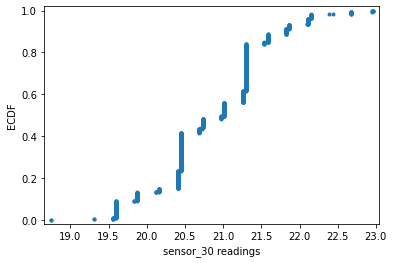

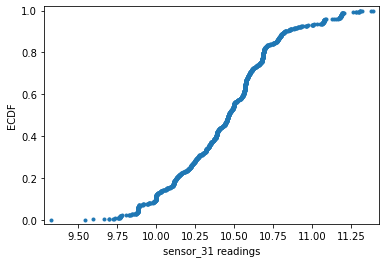

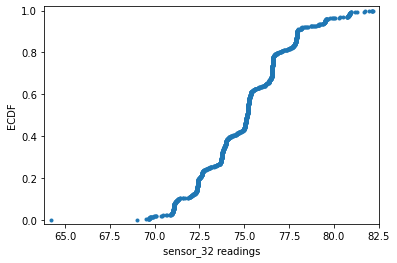

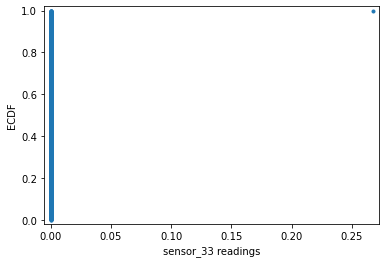

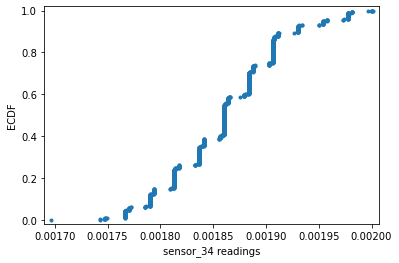

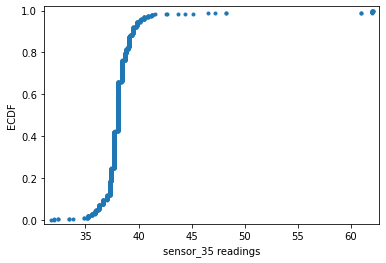

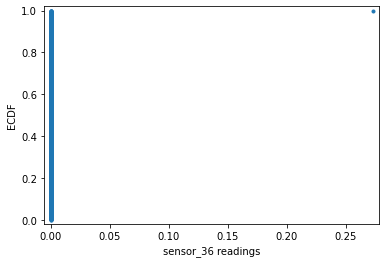

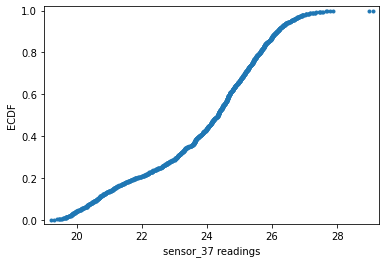

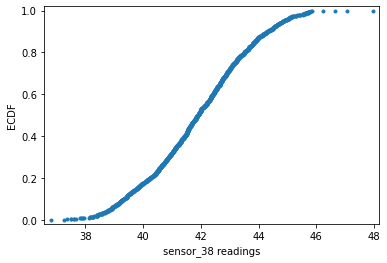

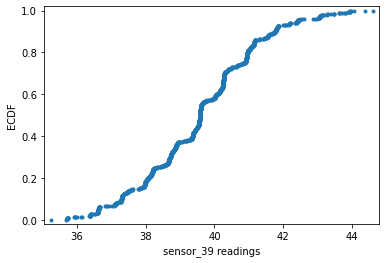

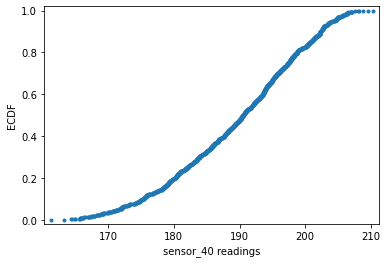

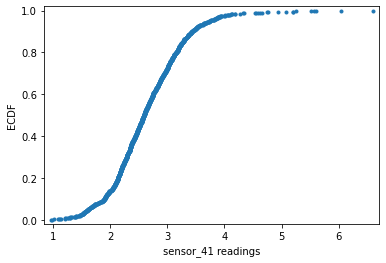

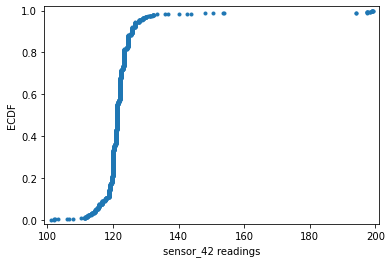

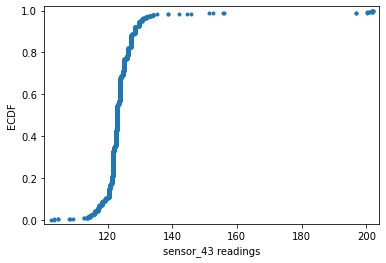

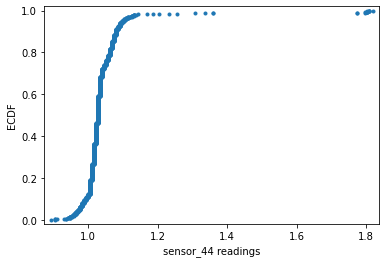

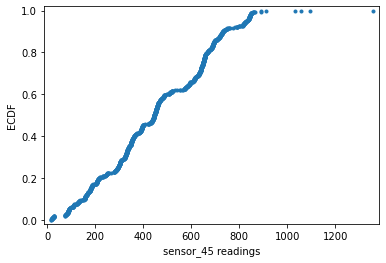

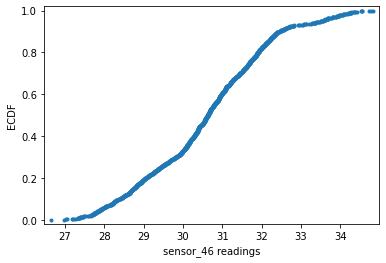

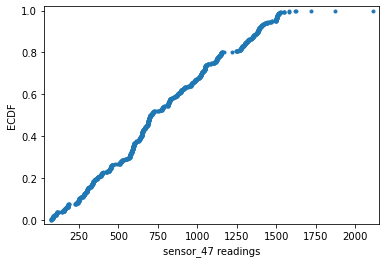

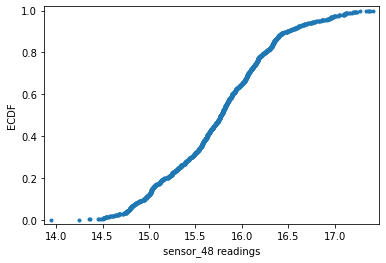

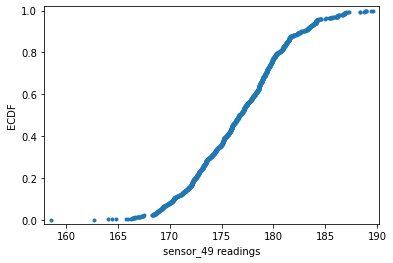

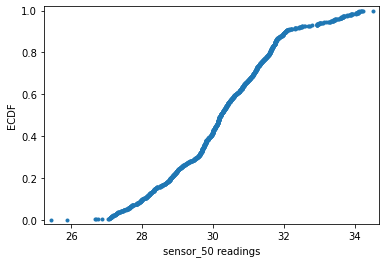

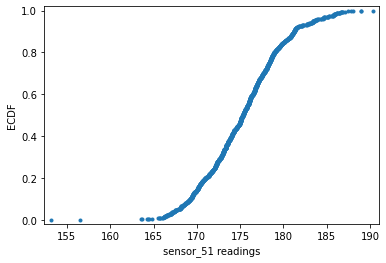

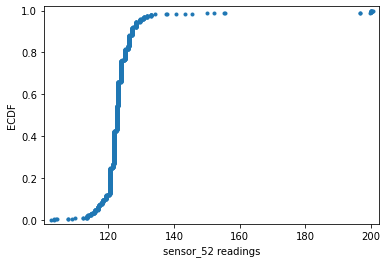

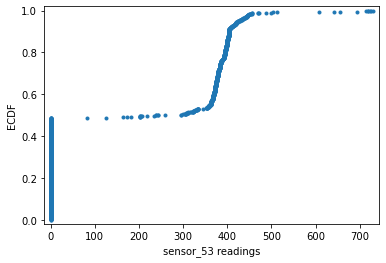

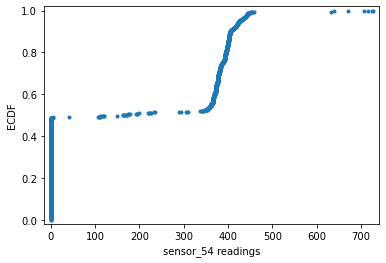

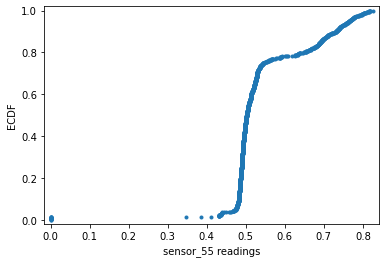

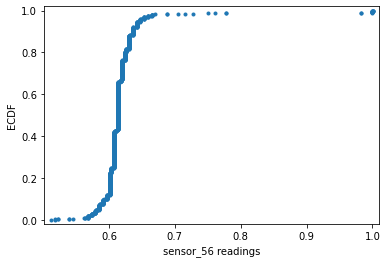

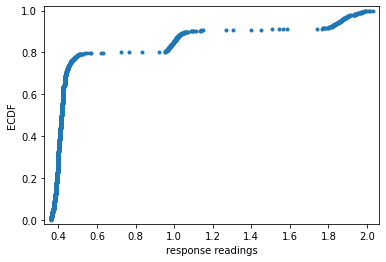

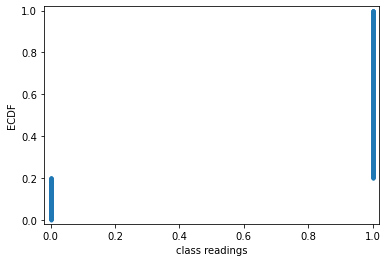

In [12]:
#ECDF plots

for n in data.columns:
    x = np.sort(data[n])
    y = np.arange(1, len(x)+1) / len(x)
    x_ecdf = plt.plot(x, y, marker='.', linestyle='none')
    plt.xlabel('%s readings' %n)
    plt.ylabel('ECDF')
    plt.margins(0.02)
    plt.show()


In [13]:
data.columns

Index(['timestamp_1_to_24', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'timestamp_25_to_56', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'sensor_52',
       'sensor_53', 'sensor_54', 'sensor_55', 'sensor_56', 'response',
       'class'],
      dtype='object')

In [14]:
data.head()

timestamp_1_to_24  sensor_1  sensor_2   sensor_3   sensor_4  \
lot wafer                                                                
2   1                   87.5  5.231203  5.176705  13.251176  42.618787   
    2                   87.5  5.196315  5.142614  13.666808  43.419169   
    3                   87.5  5.161432  5.255114  13.243853  42.981363   
    4                   87.5  5.175509  5.294318  13.671360  43.151993   
    5                   87.5  5.201729  5.127273  13.332878  43.262745   

            sensor_5  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  \
lot wafer                                                                 
2   1      43.066761       0.0  8.505448       0.0  7.267045  11.703011   
    2      43.147443       0.0  9.167583       0.0  7.607955  11.960227   
    3      42.650795       0.0  8.666924       0.0  7.295455  11.563523   
    4      42.904432       0.0  9.621476       0.0  7.613636  12.191591   
    5      43.001705       0.0  9.275963       0.0  7.335227  11.556989   

           sensor_11  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  \
lot wafer                                                                     
2   1      12.346591        0.0   0.266298   0.266298   0.266298   0.266298   
    2      12.761364        0.0   0.266162   0.266162   0.266162   0.266162   
    3      12.551136        0.0   0.266903   0.266903   0.266903   0.266903   
    4      13.215909        0.0   0.267062   0.267062   0.267062   0.267062   
    5      12.568182        0.0   0.266392   0.266392   0.266392   0.266392   

           sensor_17   sensor_18   sensor_19  sensor_20  sensor_21  \
lot wafer                                                            
2   1       6.164773  398.018165  126.723761   9.778409  79.217614   
    2       6.363636  408.363824  201.201568  10.329545  88.847159   
    3       6.164773  398.137699  113.195898   9.727273  79.772727   
    4       6.363636  408.062517  179.183085  10.164773  88.403409   
    5       6.204545  398.231636  107.544619   9.715909  80.952273   

            sensor_22   sensor_23  sensor_24  timestamp_25_to_56  sensor_25  \
lot wafer                                                                     
2   1      208.905500  467.232955   0.983864                87.5   0.001495   
    2      208.953966  467.204545   1.017557                87.5   0.001500   
    3      212.313545  477.465909   0.987557                87.5   0.001505   
    4      212.313250  477.437500   1.015966                87.5   0.001509   
    5      208.906159  467.227273   1.011364                87.5   0.001499   

            sensor_26  sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  \
lot wafer                                                                      
2   1      232.694903    60.1875     6.6875        0.0  21.821591  11.296246   
    2      245.951321    63.5625     7.0625        0.0  22.105284  10.849002   
    3      243.975941    63.0000     7.0000        0.0  21.821420  11.063067   
    4      246.357599    63.5625     7.0625        0.0  22.105057  10.858582   
    5      246.561347    63.5625     7.0625        0.0  22.104545  11.069689   

           sensor_32  sensor_33  sensor_34  sensor_35  sensor_36  sensor_37  \
lot wafer                                                                     
2   1      79.692877        0.0   0.001977  37.624962        0.0  21.595660   
    2      80.814970        0.0   0.001973  39.854000        0.0  22.763340   
    3      80.783452        0.0   0.001954  39.408217        0.0  22.018238   
    4      80.050300        0.0   0.001954  39.754566        0.0  21.757269   
    5      80.733545        0.0   0.001977  39.854118        0.0  22.053265   

           sensor_38  sensor_39   sensor_40  sensor_41   sensor_42  \
lot wafer                                                            
2   1      44.118530  42.609528  189.509110   1.660068  120.094154   
    2      45.344954  43.932713  196.95882

In [1]:
## look into correlation mapping to see if one sensor is dependent on another

In [24]:
X = data.drop('response', axis=1).values.astype('int64')
y = data['response'].values.astype('int64')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [26]:
linear_reg = LinearRegression()
logistic_reg = LogisticRegression()

In [27]:
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

In [28]:
print(linear_reg.score(X_test, y_test))
print(cross_val_score(linear_reg, X, y, cv=10))

0.6392817339718384
[ 7.35423341e-01  5.01121303e-01  5.39149974e-03  7.71533663e-01
  6.86831158e-01  1.61125683e-01  7.62180543e-01 -1.39205583e+17
 -9.89946310e-01  7.20907845e-01]


In [29]:
X = data.drop('class', axis=1).values
y = data['class'].values

In [30]:
logistic_reg.fit(X_train, y_train)
#y_pred = logistic_reg.predict(X_test)

/home/cisco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
print(logistic_reg.score(X_test, y_test))
print(cross_val_score(logistic_reg, X, y, cv=10))

0.8661616161616161


/home/cisco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cisco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

[0.71212121 0.82575758 0.78787879 0.82575758 0.84848485 0.47727273
 0.70454545 0.60606061 0.79545455 0.80916031]


/home/cisco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cisco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres